In [63]:
import datetime as dt
import logging
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [64]:
import pysat
# Set data directory if user hasn't already set one
if len(pysat.params['data_dirs']) == 0:
    # Set a directory for pysat to use for data
    pysat.params['data_dirs'] = '~/pysatDemo'
else:
    print('pysat directory has been set previously. Leaving unchanged.')


In [ ]:
import pysatNASA
import pysatSeasons

In [ ]:
# Register pysatNASA ICON IVM data plug-in. Only required once per install.
pysat.utils.registry.register(['pysatNASA.instruments.icon_ivm'])

In [65]:
# Instantiate IVM instrument data
ivm = pysat.Instrument('icon', 'ivm', inst_id='a')

# Download data
sdate = dt.datetime(2020, 1, 1)
edate = dt.datetime(2020, 1, 31)
ivm.download(sdate, edate)

# Set bounds. The download routine will update nominally update bounds but
# for demo robustness we assign them here.
ivm.bounds = (sdate, edate)

# Improvements for loading ICON metadata are currently in 
# https://github.com/pysat/pysatNASA/pull/100. 
warnings.simplefilter('ignore', UserWarning)

In [66]:
# Modify data as it is loaded to add a log ion density measurement
def add_log_dens(inst):
    """Calculate Log Ion Density.
    
    Parameters
    ----------
    inst : pysat.Instrument
        Instrument object to operate upon.
        
    """
    inst['Log_Ion_Density'] = np.log10(inst['Ion_Density'])
    
    return

# Attach to IVM
ivm.custom_attach(add_log_dens)

In [67]:
# Seasonal bin average of ICON IVM temperature and density data
results = pysatSeasons.avg.median2D(ivm, [0., 24., 24], 'Magnetic_Local_Time', 
                                    [0., 360., 30], 'Longitude',
                                    ['Ion_Temperature', 'Log_Ion_Density'])

Text(0.5, 0, 'Magnetic Local Time')

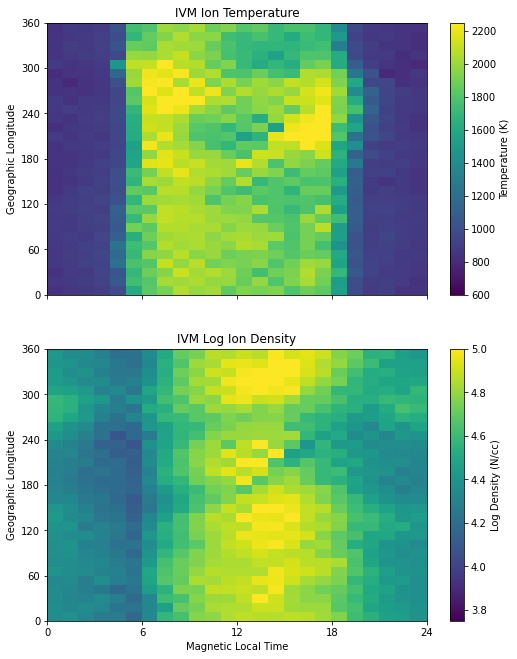

In [75]:
# The work is done, plot the results!

# Make IVM seasonal average plots
f, axarr = plt.subplots(2, sharex=True, sharey=True, figsize=(8.5, 11))
cax = []

# Ion temperature average data
temps = results['Ion_Temperature']['median']

# Values of bins along x, y
x_arr = results['Ion_Temperature']['bin_x']
y_arr = results['Ion_Temperature']['bin_y']

# Mask out NaN values
masked = np.ma.array(temps, mask=np.isnan(temps))

# Plot, NaN values are white.
# Note how the data returned from the median function is in plot order.
cax.append(axarr[0].pcolor(x_arr, y_arr,
                           masked, vmax=2250., vmin=600.,
                           edgecolors='none'))
axarr[0].set_ylim(0, 360)
axarr[0].set_xticks([0, 6, 12, 18, 24])
axarr[0].set_xlim(0, 24)
axarr[0].set_yticks(np.arange(0, 420, 60))
axarr[0].set_title('IVM Ion Temperature')
axarr[0].set_ylabel('Geographic Longitude')

cbar0 = f.colorbar(cax[0], ax=axarr[0])
cbar0.set_label('Temperature (K)')


# Ion temperature average
dens = results['Log_Ion_Density']['median']
x_arr = results['Log_Ion_Density']['bin_x']
y_arr = results['Log_Ion_Density']['bin_y']

# Mask out NaN values
masked = np.ma.array(dens, mask=np.isnan(temps))

# Plot, NaN values are white.
# Note how the data returned from the median function is in plot order.
cax.append(axarr[1].pcolor(x_arr, y_arr,
                           masked, vmax=5., vmin=3.75,
                           edgecolors='none'))
axarr[1].set_ylim(0, 360)
axarr[1].set_xticks([0, 6, 12, 18, 24])
axarr[1].set_xlim(0, 24)
axarr[1].set_yticks(np.arange(0, 420, 60))
axarr[1].set_title('IVM Log Ion Density')
axarr[1].set_ylabel('Geographic Longitude')

cbar0 = f.colorbar(cax[1], ax=axarr[1])
cbar0.set_label('Log Density (N/cc)')


axarr[1].set_xlabel('Magnetic Local Time')